# Cluster Accelerometer Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, firwin, lfilter, freqz
from scipy.signal.windows import hamming
from spectrum import pburg
from pathlib import Path

In [4]:
raw_data_path = Path('../../data/accelerometer/raw/801_1_accelerometer.pkl')

In [5]:
try:
    accel_data_array = pd.read_pickle(raw_data_path)
    # Transpose the array to ensure columns correspond to axes (x, y, z)
    # The original shape is (3, 93501), so we transpose it to (93501, 3)
    accel_data_array = accel_data_array.T
    # Convert the transposed array to a pandas DataFrame with x, y, z columns
    df_accel = pd.DataFrame(accel_data_array, columns=['x', 'y', 'z'])
    print("Data loaded, transposed, and converted to DataFrame successfully.")
    print(df_accel.head())
    
except FileNotFoundError:
    print(f"Error: The file at {raw_data_path} was not found.")
    df_accel = None

Data loaded, transposed, and converted to DataFrame successfully.
             x             y            z
0  623823.3750 -9.969514e+05 -935598.0000
1  620121.9375 -9.979850e+05 -938785.6875
2  618349.6250 -1.001284e+06 -942259.4375
3  616810.9375 -1.005281e+06 -945407.1250
4  614162.6875 -1.008645e+06 -949929.6250


In [6]:
# Convert the entire DataFrame to float64 to ensure accurate calculations
if df_accel is not None:
    df_accel = df_accel.astype(np.float64)
    print("\nDataFrame converted to float64 data type.")
    print(df_accel.head())


DataFrame converted to float64 data type.
             x             y            z
0  623823.3750 -9.969514e+05 -935598.0000
1  620121.9375 -9.979850e+05 -938785.6875
2  618349.6250 -1.001284e+06 -942259.4375
3  616810.9375 -1.005281e+06 -945407.1250
4  614162.6875 -1.008645e+06 -949929.6250


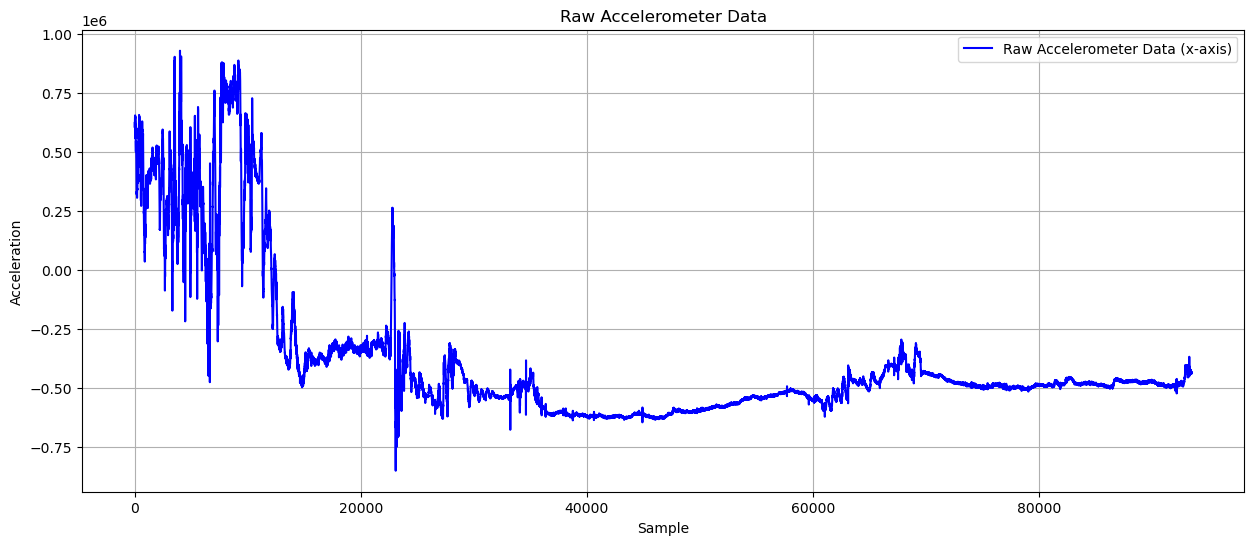

In [7]:
if df_accel is not None:
    plt.figure(figsize=(15, 6))
    plt.plot(df_accel['x'], label='Raw Accelerometer Data (x-axis)', color='blue')
    plt.title('Raw Accelerometer Data')
    plt.xlabel('Sample')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# We'll use a window size of 500 samples (5 seconds at 100 Hz)
moving_average_window = 500
# Calculate the moving average for each axis
moving_average = df_accel.rolling(window=moving_average_window, center=True).mean()
# Subtract the moving average from the calibrated data to remove drift
df_no_drift = df_accel - moving_average
# Drop the NaN values that result from the moving average calculation at the edges
df_no_drift = df_no_drift.dropna()
print("Drift removed from the data. First 5 rows of the new DataFrame:")
print(df_no_drift.head())

Drift removed from the data. First 5 rows of the new DataFrame:
                 x              y              z
250  -81730.286125    6689.587500 -153300.190000
251  -57997.090500  -33121.136625 -139961.825375
252  -43905.747688 -129845.143875 -123686.522125
253  -77284.225750 -271226.289750 -153724.605875
254 -124019.119125 -346936.119500 -216401.125750


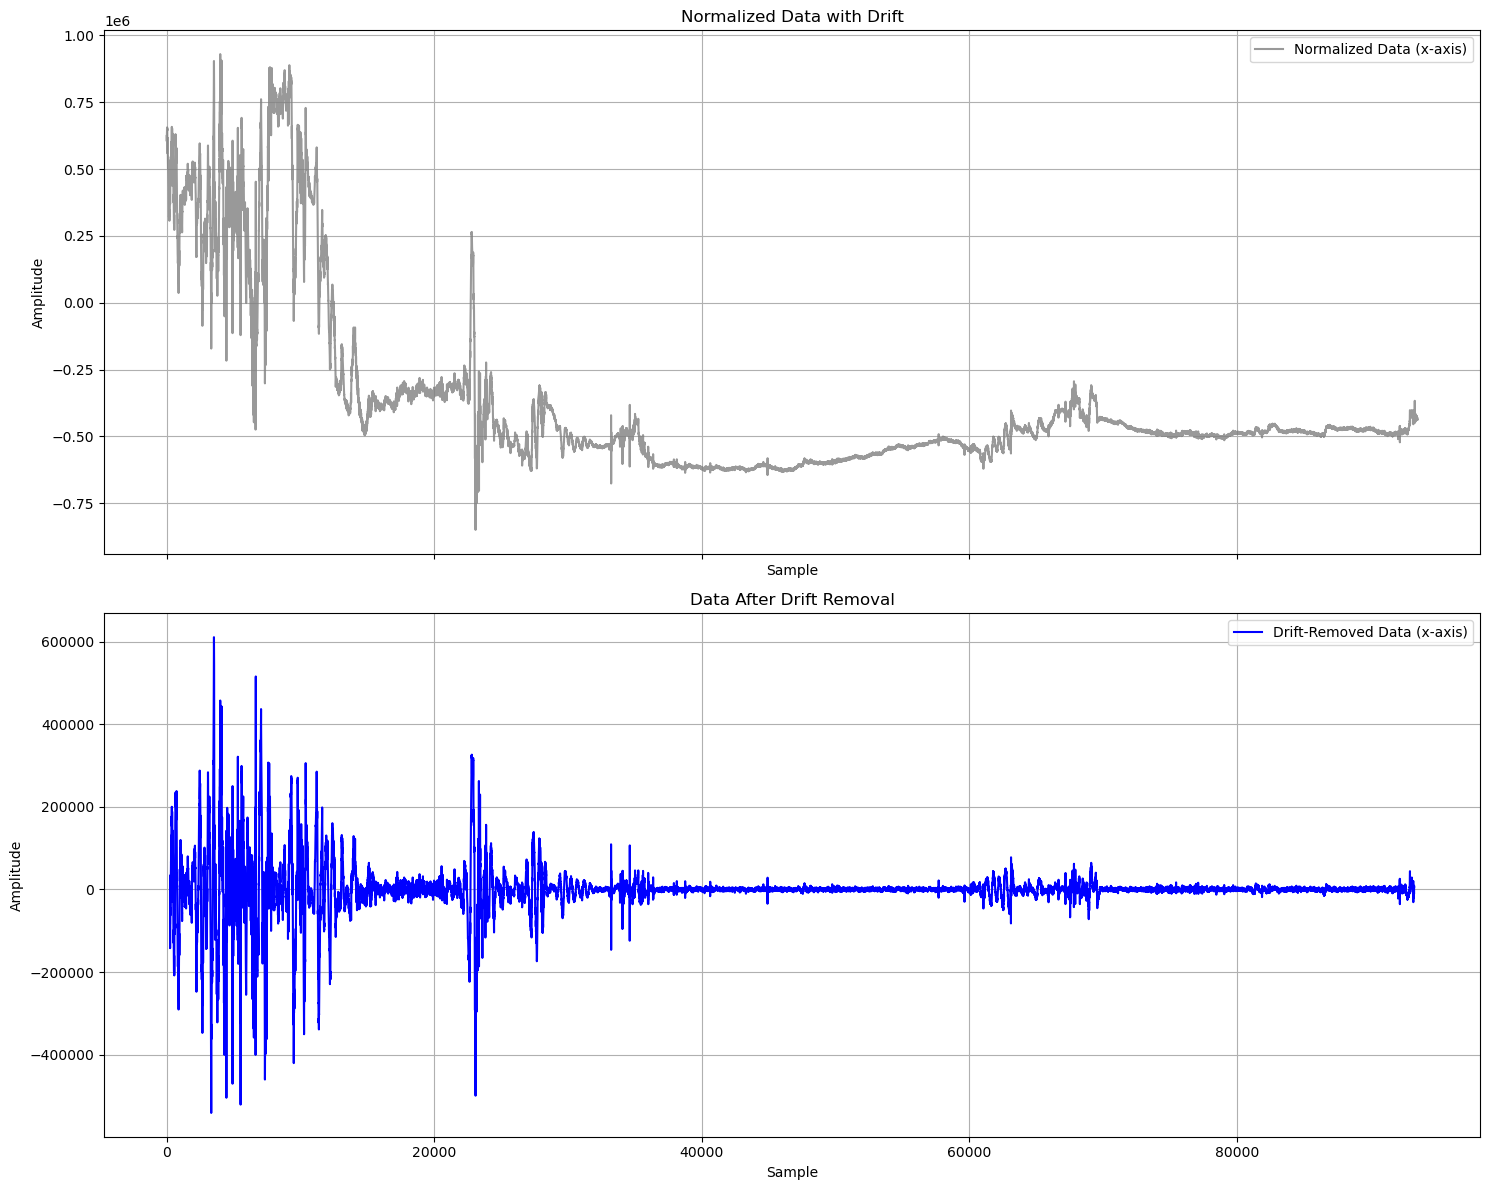

In [9]:
if df_no_drift is not None and df_accel is not None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Plot 1: Normalized data with drift
    ax1.plot(df_accel['x'], label='Normalized Data (x-axis)', color='gray', alpha=0.8)
    ax1.set_title('Normalized Data with Drift')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Data with drift removed
    ax2.plot(df_no_drift['x'], label='Drift-Removed Data (x-axis)', color='blue')
    ax2.set_title('Data After Drift Removal')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Amplitude')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [10]:
# Filter parameters from the paper
lowcut = 1.0  # Hz
highcut = 30.0 # Hz
fs = 100.0    # Sampling frequency in Hz
order = 100   # FIR filter order --> Not sure proof of concept

def fir_bandpass_filter_filtfilt(data, lowcut, highcut, fs, order):
    """
    Designs and applies a bandpass FIR filter using filtfilt for a zero-phase response.
    
    Args:
        data (pd.DataFrame): The input data to filter.
        lowcut (float): The low cutoff frequency in Hz.
        highcut (float): The high cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The filter order.
    
    Returns:
        pd.DataFrame: The filtered data.
    """
    # nyquist = 0.5 * fs
    b = firwin(order + 1, [lowcut, highcut], pass_zero=False, fs=fs)
    
    # Apply the filter using filtfilt
    y = filtfilt(b, 1.0, data.values, axis=0)
    
    # Convert the filtered array back to a DataFrame with the same columns
    df_filtered_fir = pd.DataFrame(y, columns=data.columns)
    
    return df_filtered_fir

if df_no_drift is not None:
    df_filtered_fir = fir_bandpass_filter_filtfilt(df_no_drift, lowcut, highcut, fs, order)
    print("Data filtered successfully with a zero-phase FIR filter.")
    print(df_filtered_fir.head())

Data filtered successfully with a zero-phase FIR filter.
              x              y             z
0  -1972.245801     161.427440  -3699.309893
1  22603.888668  -38698.910212  18345.339070
2  26029.148318 -142962.438389  31374.476291
3  -5715.321007 -282398.644486  11300.988774
4 -53871.785091 -359443.851294 -45761.329400


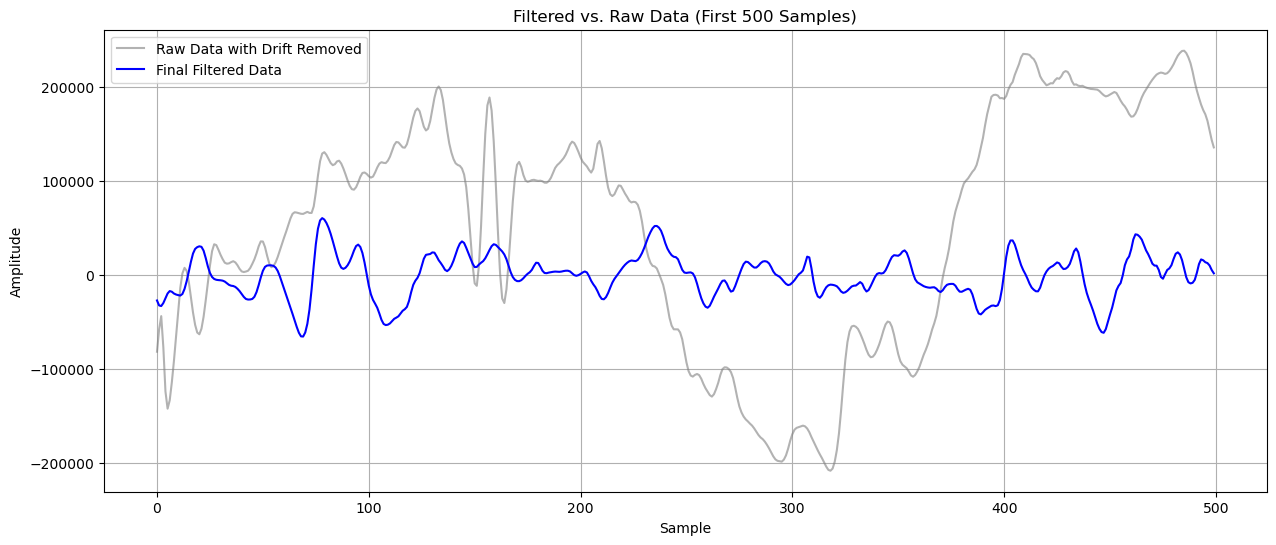

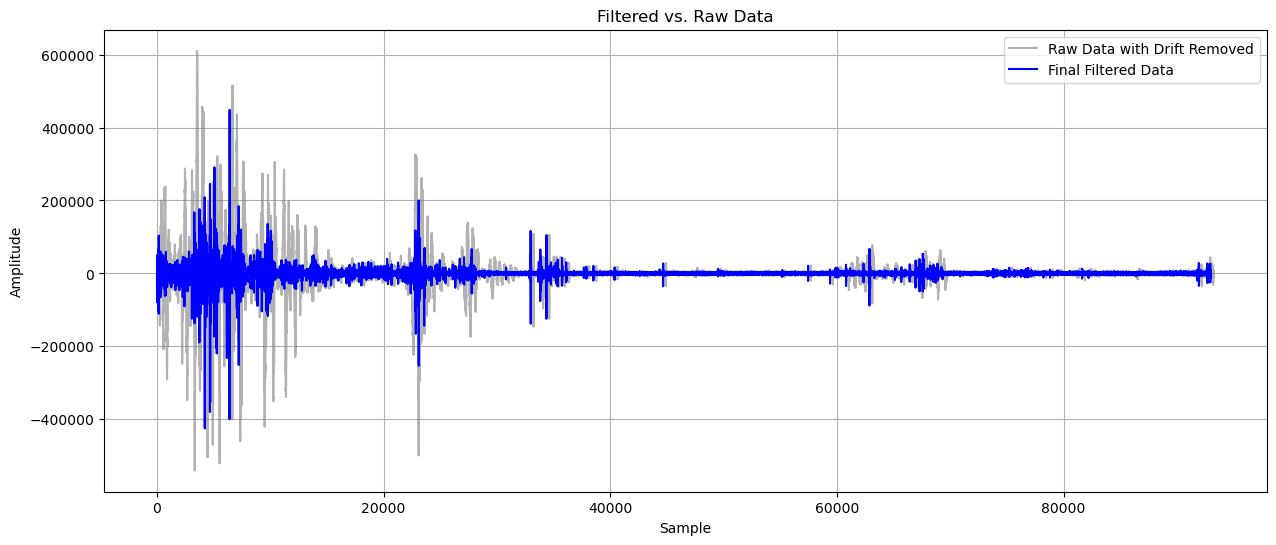

In [12]:
# Get the starting index of the df_no_drift DataFrame
start_index = df_no_drift.index[0]

# Plot the two signals for the first 500 samples
plt.figure(figsize=(15, 6))
plt.plot(df_no_drift['x'].values[:500], label='Raw Data with Drift Removed', color='gray', alpha=0.6)
plt.plot(df_filtered_fir['x'].values[start_index:start_index+500], label='Final Filtered Data', color='blue')

plt.title('Filtered vs. Raw Data (First 500 Samples)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Plot the two signals for the first 500 samples
plt.figure(figsize=(15, 6))
plt.plot(df_no_drift['x'], label='Raw Data with Drift Removed', color='gray', alpha=0.6)
plt.plot(df_filtered_fir['x'], label='Final Filtered Data', color='blue')

plt.title('Filtered vs. Raw Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Parameters from the paper
fs = 100.0  # Sampling frequency in Hz
window_duration = 3.0  # seconds
overlap_ratio = 0.90

# Calculate window and step sizes in samples
window_samples = int(window_duration * fs)
overlap_samples = int(overlap_ratio * window_samples)
step_samples = window_samples - overlap_samples

# Check the calculated values
print(f"Window size: {window_samples} samples")
print(f"Overlap: {overlap_samples} samples")
print(f"Step size: {step_samples} samples")

def apply_sliding_window(data_series, window_samples, step_samples):
    """
    Applies a sliding Hamming window to a time series.
    
    Args:
        data_series (pd.Series): The time series data for one axis.
        window_samples (int): The number of samples in each window.
        step_samples (int): The number of samples to step for each window.

    Returns:
        list: A list of NumPy arrays, where each array is a windowed segment.
    """
    windowed_segments = []
    
    # Create the Hamming window array
    ham_window = hamming(window_samples, sym=True)
    
    # Iterate through the data with the specified step size
    for i in range(0, len(data_series) - window_samples + 1, step_samples):
        segment = data_series[i : i + window_samples].values
        # Apply the Hamming window element-wise
        windowed_segment = segment * ham_window
        windowed_segments.append(windowed_segment)
        
    return windowed_segments

# Apply windowing to each filtered axis
if df_filtered_fir is not None:
    windowed_data = {}
    for axis in ['x', 'y', 'z']:
        windowed_data[axis] = apply_sliding_window(df_filtered_fir[axis], window_samples, step_samples)
        
    print("\nWindowing completed for all axes.")
    print(f"Number of windows for x-axis: {len(windowed_data['x'])}")
    print(f"Shape of the first window: {windowed_data['x'][0].shape}")
    print(f"Shape of thes second window: {windowed_data['x'][1].shape}")

Window size: 300 samples
Overlap: 270 samples
Step size: 30 samples

Windowing completed for all axes.
Number of windows for x-axis: 3091
Shape of the first window: (300,)
Shape of thes second window: (300,)


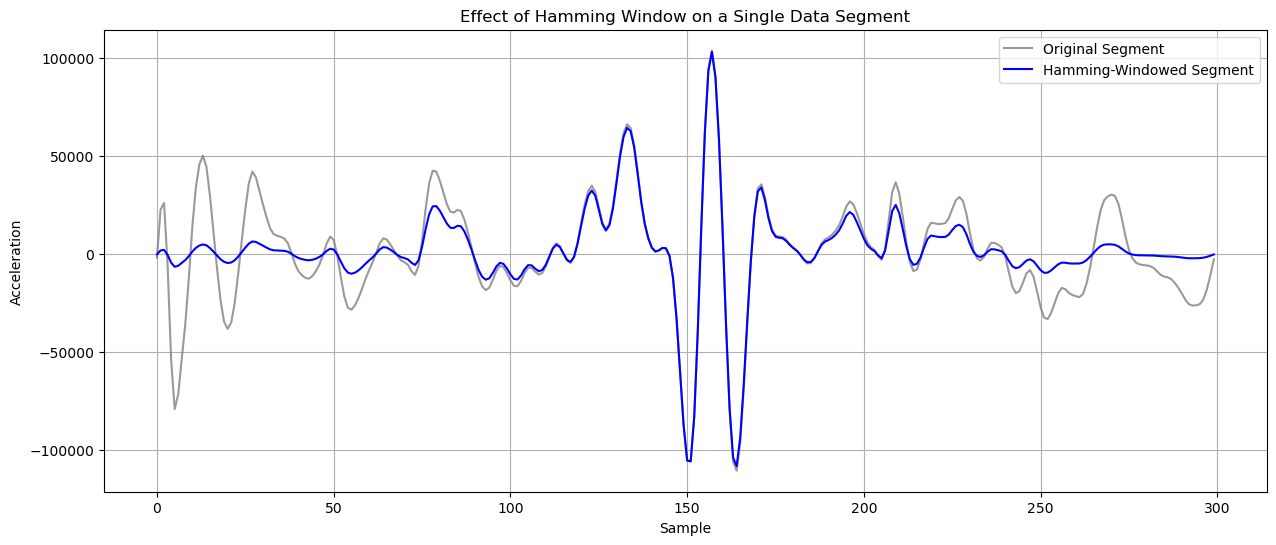

In [14]:
# Get the first segment of the filtered data before windowing
first_segment = df_filtered_fir['x'].values[0:window_samples]

# Apply the Hamming window to this segment
first_windowed_segment = first_segment * hamming(window_samples, sym=True)

# Plot both the original and windowed segments for comparison
plt.figure(figsize=(15, 6))
plt.plot(first_segment, label='Original Segment', color='gray', alpha=0.8)
plt.plot(first_windowed_segment, label='Hamming-Windowed Segment', color='blue')
plt.title('Effect of Hamming Window on a Single Data Segment')
plt.xlabel('Sample')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

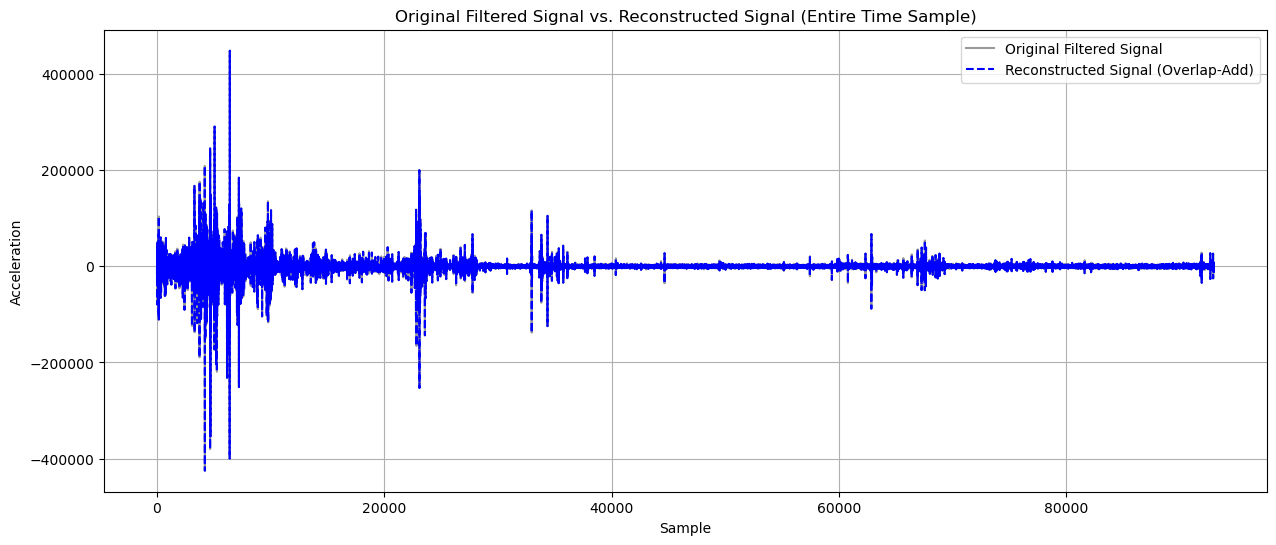

First 10 values of the segment:
[ -157.77966408  1810.60677883  2092.90493815  -462.44825327
 -4397.23530693 -6536.81566942 -5998.07094512 -4546.72426628
 -3106.49163089 -1114.38744678]

Stats of the segment:
Max value: 103223.1878
Min value: -108324.2906
Mean value: 1515.0112


In [16]:
# Get the first three windows from your filtered data for visualization
first_window = df_filtered_fir['x'].values[0:window_samples]
second_window = df_filtered_fir['x'].values[step_samples:step_samples + window_samples]
third_window = df_filtered_fir['x'].values[2*step_samples:2*step_samples + window_samples]

# Create the Hamming window array
ham_window = hamming(window_samples, sym=True)

# Apply the window to each segment
first_windowed = first_window * ham_window
second_windowed = second_window * ham_window
third_windowed = third_window * ham_window

# To check if the windows overlap correctly, we can plot them
def reconstruct_signal(data_series, window_samples, step_samples):
        total_length = len(data_series)
        reconstructed_signal = np.zeros(total_length)
        sum_of_windows = np.zeros(total_length)
        
        # Iterate through segments and sum them up
        for i in range(0, total_length - window_samples + 1, step_samples):
            segment = data_series.values[i : i + window_samples]
            windowed_segment = segment * ham_window
            reconstructed_signal[i : i + window_samples] += windowed_segment
            sum_of_windows[i : i + window_samples] += ham_window
        
        # Avoid division by zero
        sum_of_windows[sum_of_windows == 0] = 1e-6
        
        # Normalize the signal by the sum of overlapping windows
        reconstructed_signal /= sum_of_windows
        
        return reconstructed_signal

# Reconstruct the signal for the x-axis
reconstructed_signal_x = reconstruct_signal(df_filtered_fir['x'], window_samples, step_samples)

# Plot the original vs. reconstructed signal
plt.figure(figsize=(15, 6))
plt.plot(df_filtered_fir['x'], label='Original Filtered Signal', color='gray', alpha=0.8)
plt.plot(reconstructed_signal_x, label='Reconstructed Signal (Overlap-Add)', color='blue', linestyle='--')
plt.title('Original Filtered Signal vs. Reconstructed Signal (Entire Time Sample)')
plt.xlabel('Sample')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

# Get the first segment from the x-axis
segment = windowed_data['x'][0]

# Print the values and stats of the segment
print("First 10 values of the segment:")
print(segment[:10])
print("\nStats of the segment:")
print(f"Max value: {np.max(segment):.4f}")
print(f"Min value: {np.min(segment):.4f}")
print(f"Mean value: {np.mean(segment):.4f}")